In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

# Step 1: Load Dataset
file_path = "/content/drive/MyDrive/Colab Notebooks/IIoT_Malware_Timeseries_Dataset.csv"
data = pd.read_csv(file_path)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45289 entries, 0 to 45288
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Timestamp                 45289 non-null  object 
 1   Packet Size               45174 non-null  float64
 2   Packet Length             45219 non-null  float64
 3   Inter-Arrival Time        45289 non-null  float64
 4   Protocol Type             45289 non-null  object 
 5   Flags                     45289 non-null  object 
 6   Source IP                 45289 non-null  int64  
 7   Destination IP            45289 non-null  int64  
 8   Source Port               45289 non-null  int64  
 9   Destination Port          45289 non-null  int64  
 10  Flow Duration             44991 non-null  float64
 11  Total Packets             44841 non-null  float64
 12  Total Bytes               44988 non-null  float64
 13  Average Packet Size       44541 non-null  float64
 14  Packet

In [ ]:
# Step 2: Preprocess Dataset
# Convert datetime columns to numeric (if any)
for col in data.columns:
    if pd.api.types.is_datetime64_any_dtype(data[col]) or pd.to_datetime(data[col], errors='coerce').notnull().all():
        data[col] = pd.to_datetime(data[col], errors='coerce').astype('int64') // 10**9

# Handle missing values
for col in data.columns:
    if data[col].dtype == 'object':
        data[col].fillna(data[col].mode()[0], inplace=True)  # Fill categorical columns with mode
    else:
        data[col].fillna(data[col].mean(), inplace=True)  # Fill numeric columns with mean

# Encode categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le


<ipython-input-3-b05e59396278>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  if pd.api.types.is_datetime64_any_dtype(data[col]) or pd.to_datetime(data[col], errors='coerce').notnull().all():
<ipython-input-3-b05e59396278>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  if pd.api.types.is_datetime64_any_dtype(data[col]) or pd.to_datetime(data[col], errors='coerce').notnull().all():
<ipython-input-3-b05e59396278>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  if pd.api.types.is_datetime64_any_dtype(data[col]) or pd.to_datetime(data[col], errors='coerce').notnull().all()

In [ ]:
# Step 3: Prepare Features and Target
X = data.drop(columns=['Label'])  # Replace 'Attack Type' with the actual target column name
y = data['Label']

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape target for CNN compatibility (One-hot encode for multi-class classification)
if len(y.unique()) > 2:
    y = pd.get_dummies(y).values

# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Reshape X for CNN input
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [ ]:
# Step 4: Build CNN Model
model = Sequential([
    tf.keras.Input(shape=(X_train.shape[1], 1)),
    Conv1D(filters=64, kernel_size=3, activation="relu", kernel_regularizer=l2(0.01)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(filters=128, kernel_size=3, activation="relu", kernel_regularizer=l2(0.01)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(256, activation="relu", kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    Dense(y_train.shape[1] if len(y_train.shape) > 1 else 1, activation="softmax" if len(y_train.shape) > 1 else "sigmoid")
])


In [ ]:
# Step 5: Compile the Model
loss = "categorical_crossentropy" if len(y_train.shape) > 1 else "binary_crossentropy"
model.compile(optimizer="Adam", loss=loss, metrics=["accuracy"])


In [ ]:
# Step 6: Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=16,
    verbose=1
)


Epoch 1/20
1982/1982 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.6965 - loss: 1.6773 - val_accuracy: 0.7020 - val_loss: 1.0813
Epoch 2/20
1982/1982 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6988 - loss: 1.0906 - val_accuracy: 0.7020 - val_loss: 1.0808
Epoch 3/20
1982/1982 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7015 - loss: 1.0868 - val_accuracy: 0.7020 - val_loss: 1.0808
Epoch 4/20
1982/1982 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7010 - loss: 1.0864 - val_accuracy: 0.7020 - val_loss: 1.0814
Epoch 5/20
1982/1982 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7012 - loss: 1.0863 - val_accuracy: 0.7020 - val_loss: 1.0800
Epoch 6/20
1982/1982 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6933 - loss: 1.1050 - val_accuracy: 0.7020 - val_loss: 1.0800
Epoch 7/20
1982/1982 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.6964 - loss: 1.0976 - val_accuracy: 0.7020 - val_loss: 1.0808
Epoch 8/20
1982/1982 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7014 - loss: 1.0830 

In [ ]:
# Step 7: Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7057 - loss: 1.0722
Test Loss: 1.0915067195892334
Test Accuracy: 0.6972328424453735


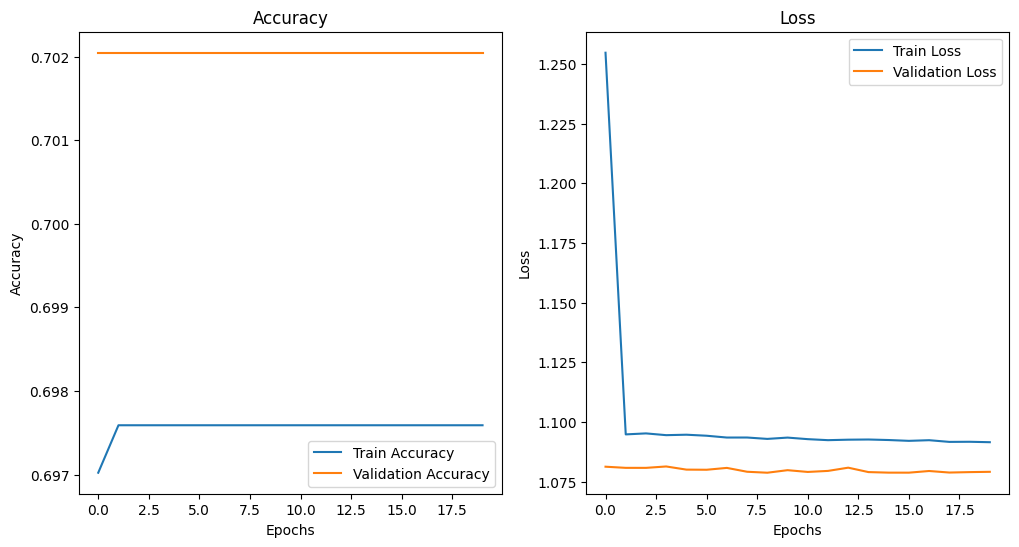

In [ ]:
# Plot training history
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()